In [42]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint  # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore

In [43]:
# 2. Charger les données
# Charger les données prétraitées

df = pd.read_csv("../datasets/BeerWineLiquor.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

# if len(df.columns) == 1 : df['target'] = df[df.columns[-1]]



# Identifier les colonnes cibles (toutes sauf la date)
target_column = df.columns[-1]

feature_columns = [col for col in df.columns if col != target_column] if len(df.columns) > 1 else [target_column]




In [44]:
# 3. Normalisation des données
# LSTM fonctionne mieux avec des données normalisées entre 0 et 1 :
scalers = {}
scaled_data = {}

scalers = {}

for column in df.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data[column] = scaler.fit_transform(df[[column]])
    scaled_data[column] = scaled_data[column].flatten()
    scalers[column] = scaler

scaled_data = pd.DataFrame(scaled_data, index=df.index)
scaled_data.reset_index(inplace=True)
train_size = int(len(scaled_data) * 0.8)
X_train = scaled_data.iloc[:train_size][feature_columns]
y_train = scaled_data.iloc[:train_size][target_column]
X_test = scaled_data.iloc[train_size:][feature_columns]
y_test = scaled_data.iloc[train_size:][target_column]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# scaler_X = MinMaxScaler(feature_range=(0, 1))
# scaler_y = MinMaxScaler(feature_range=(0, 1))

# # Fit scaler on training data only
# X_train_scaled = scaler_X.fit_transform(X_train)
# y_train_scaled = scaler_X.transform(pd.DataFrame(y_train))
# # y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))

# # Transform test data with the same scaler
# X_test_scaled = scaler_X.transform(X_test)
# y_test_scaled = scaler_X.transform(pd.DataFrame(y_test))

y_train

0      0.001643
1      0.008215
2      0.019717
3      0.035736
4      0.065927
         ...   
254    0.436024
255    0.408092
256    0.502362
257    0.474019
258    0.520230
Name: beer, Length: 259, dtype: float64

In [45]:
X_train

,beer
0,0.001643
1,0.008215
2,0.019717
3,0.035736
4,0.065927
...,...
254,0.436024
255,0.408092
256,0.502362
257,0.474019


In [46]:
# # 4. Transformer les données en séquences pour LSTM
# def create_sequences(data, seq_length=12):
#     sequences = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         sequences.append(seq)
#     return np.array(sequences)

# #seq_length: Nombre de pas de temps utilisés pour la prédiction
# detected_freq = pd.infer_freq(df.index)
# print("***",detected_freq,"***")
# if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
#     seq_length = 10
# elif detected_freq in ["MS", "M"]:# "justify your choices"
#     seq_length = 12
# else:
#     seq_length = 1
# print(seq_length)
# # Dictionnaire pour stocker les séquences

# X_train_seq = create_sequences(X_train, seq_length=seq_length)
# y_train_seq = create_sequences(y_train, seq_length=seq_length)
# X_test_seq = create_sequences(X_test, seq_length=seq_length)
# y_test_seq = create_sequences(y_test, seq_length=seq_length)


In [47]:
def create_sequences(X, y, seq_length=12):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i + seq_length])  # Predict one step ahead
    return np.array(Xs), np.array(ys)

# Detect frequency to set sequence length dynamically
detected_freq = pd.infer_freq(df.index)
print("***", detected_freq, "***")

if detected_freq in ["D", "B"]:  # Daily or Business Days
    seq_length = 10
elif detected_freq in ["MS", "M"]:  # Monthly Start or Monthly
    seq_length = 12
else:
    seq_length = 1

print("Sequence length:", seq_length)

# Prepare the data (use .values to get numpy arrays)
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, seq_length)


*** MS ***
Sequence length: 12


In [ ]:
def objective(trial):
    model = Sequential()

    # Hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = trial.suggest_int('units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        if i == 0:
            model.add(LSTM(units,activation='tanh', return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        else:
            model.add(LSTM(units,activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=1, activation='linear'))  # Regression

    model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mse'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, "val_loss")

    # Save best model of this trial
    # model_path = f"model_trial_{trial.number}.keras"
    # checkpoint = ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True)

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping, pruning_callback],
        verbose=0
    )

    return min(history.history["val_loss"])

In [49]:
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ", study.best_trial.params)


[I 2025-04-15 22:17:47,980] A new study created in memory with name: no-name-8877cca1-d44e-4b42-b815-c9f402374aff
C:\Users\raedb\AppData\Local\Temp\ipykernel_18772\3543206000.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Restoring model weights from the end of the best epoch: 50.


[I 2025-04-15 22:18:01,662] Trial 0 finished with value: 0.012996196746826172 and parameters: {'n_layers': 3, 'units': 35, 'dropout_rate': 0.11242020915269967, 'learning_rate': 6.439351501709519e-05}. Best is trial 0 with value: 0.012996196746826172.


Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


[I 2025-04-15 22:18:09,462] Trial 1 finished with value: 0.013564292341470718 and parameters: {'n_layers': 3, 'units': 79, 'dropout_rate': 0.22692700250216055, 'learning_rate': 0.00712146051688217}. Best is trial 0 with value: 0.012996196746826172.


Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


[I 2025-04-15 22:18:33,306] Trial 2 finished with value: 0.012138936668634415 and parameters: {'n_layers': 3, 'units': 92, 'dropout_rate': 0.4978982710636115, 'learning_rate': 6.809832030591497e-05}. Best is trial 2 with value: 0.012138936668634415.


Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


[I 2025-04-15 22:18:45,323] Trial 3 finished with value: 0.012804119847714901 and parameters: {'n_layers': 2, 'units': 117, 'dropout_rate': 0.17427801774845247, 'learning_rate': 0.0006197231032428018}. Best is trial 2 with value: 0.012138936668634415.


Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.


[I 2025-04-15 22:18:49,345] Trial 4 finished with value: 0.0145903080701828 and parameters: {'n_layers': 1, 'units': 124, 'dropout_rate': 0.48431057376677966, 'learning_rate': 0.002354814943378967}. Best is trial 2 with value: 0.012138936668634415.
[I 2025-04-15 22:18:52,244] Trial 5 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:18:59,520] Trial 6 pruned. Trial was pruned at epoch 7.
[I 2025-04-15 22:19:02,152] Trial 7 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:19:08,548] Trial 8 pruned. Trial was pruned at epoch 6.
[I 2025-04-15 22:19:11,349] Trial 9 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:19:19,508] Trial 10 pruned. Trial was pruned at epoch 24.
[I 2025-04-15 22:19:27,124] Trial 11 pruned. Trial was pruned at epoch 24.


Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


[I 2025-04-15 22:19:34,740] Trial 12 finished with value: 0.013662014156579971 and parameters: {'n_layers': 2, 'units': 100, 'dropout_rate': 0.23935477438116085, 'learning_rate': 0.0015678160824778007}. Best is trial 2 with value: 0.012138936668634415.
[I 2025-04-15 22:19:50,669] Trial 13 pruned. Trial was pruned at epoch 24.
[I 2025-04-15 22:20:00,605] Trial 14 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:20:14,995] Trial 15 pruned. Trial was pruned at epoch 5.


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


[I 2025-04-15 22:20:30,963] Trial 16 finished with value: 0.013159430585801601 and parameters: {'n_layers': 2, 'units': 113, 'dropout_rate': 0.18101858399769583, 'learning_rate': 0.0011760500675754057}. Best is trial 2 with value: 0.012138936668634415.
[I 2025-04-15 22:20:44,535] Trial 17 pruned. Trial was pruned at epoch 5.


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-04-15 22:20:54,652] Trial 18 finished with value: 0.013717440888285637 and parameters: {'n_layers': 2, 'units': 115, 'dropout_rate': 0.4901283033944784, 'learning_rate': 0.00020669515827142088}. Best is trial 2 with value: 0.012138936668634415.
[I 2025-04-15 22:21:04,318] Trial 19 pruned. Trial was pruned at epoch 5.


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-04-15 22:21:18,601] Trial 20 finished with value: 0.012970303185284138 and parameters: {'n_layers': 3, 'units': 95, 'dropout_rate': 0.14774687687852261, 'learning_rate': 0.0007573239109928065}. Best is trial 2 with value: 0.012138936668634415.


Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-04-15 22:21:32,735] Trial 21 finished with value: 0.013718371279537678 and parameters: {'n_layers': 3, 'units': 95, 'dropout_rate': 0.14982852185977139, 'learning_rate': 0.0007148368079003635}. Best is trial 2 with value: 0.012138936668634415.


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-04-15 22:21:47,176] Trial 22 finished with value: 0.014079288579523563 and parameters: {'n_layers': 3, 'units': 76, 'dropout_rate': 0.14557438747503362, 'learning_rate': 0.00026657561397101575}. Best is trial 2 with value: 0.012138936668634415.


Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


[I 2025-04-15 22:21:55,235] Trial 23 finished with value: 0.012640816159546375 and parameters: {'n_layers': 3, 'units': 107, 'dropout_rate': 0.22959428857580255, 'learning_rate': 0.0006604744190834604}. Best is trial 2 with value: 0.012138936668634415.


Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


[I 2025-04-15 22:22:05,845] Trial 24 finished with value: 0.013703753240406513 and parameters: {'n_layers': 2, 'units': 108, 'dropout_rate': 0.22339424826385273, 'learning_rate': 0.00260253491219579}. Best is trial 2 with value: 0.012138936668634415.


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


[I 2025-04-15 22:22:26,605] Trial 25 finished with value: 0.012181245721876621 and parameters: {'n_layers': 3, 'units': 121, 'dropout_rate': 0.27194099404774225, 'learning_rate': 0.0004447166008415951}. Best is trial 2 with value: 0.012138936668634415.
[I 2025-04-15 22:22:39,706] Trial 26 pruned. Trial was pruned at epoch 5.


Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


[I 2025-04-15 22:23:00,655] Trial 27 finished with value: 0.012277566827833652 and parameters: {'n_layers': 3, 'units': 86, 'dropout_rate': 0.3382215908862656, 'learning_rate': 0.0003432188316158866}. Best is trial 2 with value: 0.012138936668634415.
[I 2025-04-15 22:23:12,737] Trial 28 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:23:24,963] Trial 29 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:23:37,096] Trial 30 pruned. Trial was pruned at epoch 5.


Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.


[I 2025-04-15 22:23:53,239] Trial 31 finished with value: 0.012653060257434845 and parameters: {'n_layers': 3, 'units': 85, 'dropout_rate': 0.2574451944198105, 'learning_rate': 0.0011536562506363503}. Best is trial 2 with value: 0.012138936668634415.


Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


[I 2025-04-15 22:24:22,836] Trial 32 finished with value: 0.011720319278538227 and parameters: {'n_layers': 3, 'units': 98, 'dropout_rate': 0.21257005968194673, 'learning_rate': 0.00023862863113189016}. Best is trial 32 with value: 0.011720319278538227.


Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


[I 2025-04-15 22:24:48,938] Trial 33 finished with value: 0.011768990196287632 and parameters: {'n_layers': 3, 'units': 79, 'dropout_rate': 0.2975280573291982, 'learning_rate': 0.00023299784242473328}. Best is trial 32 with value: 0.011720319278538227.
[I 2025-04-15 22:25:03,504] Trial 34 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:25:17,006] Trial 35 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:25:30,794] Trial 36 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:25:53,463] Trial 37 pruned. Trial was pruned at epoch 30.
[I 2025-04-15 22:26:06,613] Trial 38 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:26:20,392] Trial 39 pruned. Trial was pruned at epoch 5.


Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


[I 2025-04-15 22:26:36,156] Trial 40 finished with value: 0.012790543958544731 and parameters: {'n_layers': 3, 'units': 101, 'dropout_rate': 0.3784287683718195, 'learning_rate': 0.0004961128598042915}. Best is trial 32 with value: 0.011720319278538227.


Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


[I 2025-04-15 22:26:51,762] Trial 41 finished with value: 0.012637305073440075 and parameters: {'n_layers': 3, 'units': 84, 'dropout_rate': 0.455013310070911, 'learning_rate': 0.0004196610209291733}. Best is trial 32 with value: 0.011720319278538227.
[I 2025-04-15 22:27:05,357] Trial 42 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:27:17,059] Trial 43 pruned. Trial was pruned at epoch 5.
[I 2025-04-15 22:27:22,133] Trial 44 pruned. Trial was pruned at epoch 5.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.


[I 2025-04-15 22:27:38,850] Trial 45 finished with value: 0.01232527568936348 and parameters: {'n_layers': 3, 'units': 62, 'dropout_rate': 0.4691773388803668, 'learning_rate': 0.0009987467219818497}. Best is trial 32 with value: 0.011720319278538227.


Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-04-15 22:27:51,439] Trial 46 finished with value: 0.013972352258861065 and parameters: {'n_layers': 3, 'units': 91, 'dropout_rate': 0.19382913539628543, 'learning_rate': 0.00031136214708121605}. Best is trial 32 with value: 0.011720319278538227.


Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


[I 2025-04-15 22:28:04,646] Trial 47 finished with value: 0.013597280718386173 and parameters: {'n_layers': 3, 'units': 56, 'dropout_rate': 0.3061111543405606, 'learning_rate': 0.008384518897018595}. Best is trial 32 with value: 0.011720319278538227.
[I 2025-04-15 22:28:17,113] Trial 48 pruned. Trial was pruned at epoch 5.


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-04-15 22:28:26,787] Trial 49 finished with value: 0.013775614090263844 and parameters: {'n_layers': 2, 'units': 118, 'dropout_rate': 0.11015201927458176, 'learning_rate': 0.000176388815508953}. Best is trial 32 with value: 0.011720319278538227.


Best trial:
  Value:  0.011720319278538227
  Params:  {'n_layers': 3, 'units': 98, 'dropout_rate': 0.21257005968194673, 'learning_rate': 0.00023862863113189016}


In [50]:
# study.best_params

In [51]:
# 6. Définir l'architecture du modèle LSTM
def build_lstm_model():
    model = Sequential([
        LSTM(200, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        LSTM(200, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_lstm_model_2():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(Dense(1))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model


In [65]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model = build_lstm_model()
# history = model.fit(
#     X_train_seq, y_train_seq,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping],
#     verbose=1
# )

best_params = study.best_params

model = Sequential()
for i in range(best_params['n_layers']):
    return_seq = (i < best_params['n_layers'] - 1)
    if i == 0:
        model.add(LSTM(best_params['units'], activation='relu', return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    else:
        model.add(LSTM(best_params['units'], activation='relu', return_sequences=return_seq))
    model.add(Dropout(best_params['dropout_rate']))

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer=Adam(best_params['learning_rate']), loss='mse', metrics=['mse'])

model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=16,
    # callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5, restore_best_weights=True)],
    verbose=1
)


train_loss = model.evaluate(X_train_seq, y_train_seq, verbose=0)
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test_seq)
predictions

Epoch 1/100


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.3036 - val_mse: 0.3036
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.1437 - val_mse: 0.1437
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 -

array([[0.54067224],
       [0.46302465],
       [0.5005238 ],
       [0.5647135 ],
       [0.78633   ],
       [0.39567944],
       [0.39717552],
       [0.45486706],
       [0.47367796],
       [0.5528652 ],
       [0.5361361 ],
       [0.57528204],
       [0.56848544],
       [0.5053167 ],
       [0.56335133],
       [0.5970487 ],
       [0.87111795],
       [0.43453586],
       [0.43301582],
       [0.49772742],
       [0.51196223],
       [0.5933951 ],
       [0.5795036 ],
       [0.63268906],
       [0.58161974],
       [0.5588273 ],
       [0.6056836 ],
       [0.64359254],
       [0.93223286],
       [0.45184103],
       [0.4877304 ],
       [0.53977144],
       [0.56186634],
       [0.6166261 ],
       [0.63554454],
       [0.6819921 ],
       [0.634616  ],
       [0.6339946 ],
       [0.6500522 ],
       [0.7144631 ],
       [0.9944177 ],
       [0.47701254],
       [0.4974159 ],
       [0.58199817],
       [0.59442073],
       [0.66499543],
       [0.67474556],
       [0.696

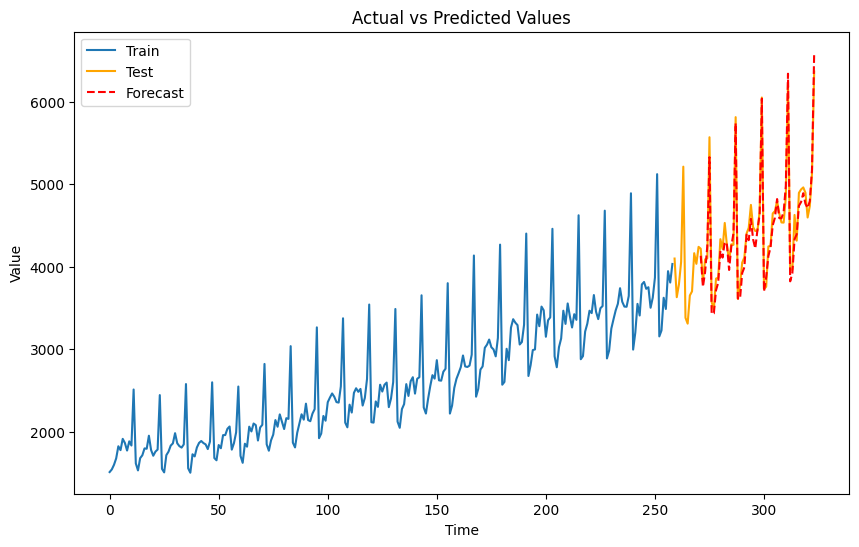

In [66]:
y_test_rescaled = scalers[target_column].inverse_transform(y_test.values.reshape(-1, 1))  # For actual values
y_pred_rescaled = scalers[target_column].inverse_transform(predictions)
y_train_rescaled = scalers[target_column].inverse_transform(y_train.values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train_rescaled, label="Train")
plt.plot(y_test.index, y_test_rescaled, label="Test", color="orange")
plt.plot(y_test[seq_length:].index, y_pred_rescaled.flatten(), label="Forecast", linestyle="dashed", color="red")
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [67]:
mse = mean_squared_error(y_test[seq_length:], predictions)
mae = mean_absolute_error(y_test[seq_length:], predictions)
r2 = r2_score(y_test[seq_length:],predictions)
mape=mean_absolute_percentage_error(y_test[seq_length:], predictions)

print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Absolute Percentage Error: 0.036085986998549084
Mean Absolute Error: 0.021759582806098812
Mean Squared Error: 0.0006567737931278966
R2 Score: 0.9607135303187537
